## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence


C:\Users\direl\OneDrive - The University of Sydney (Students)\Documents\Thesis\Code\waveglow\tacotron2\plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\direl\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\direl\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\direl\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\direl\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in laun

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

#### Load WaveGlow for mel2audio synthesis

In [5]:
from os import listdir
from os.path import isfile, join
print([f for f in listdir("../checkpoints") if isfile(join("../checkpoints", f))])


# waveglow_path = './waveglow_old.pt'
waveglow_path = '../checkpoints/waveglow_402000'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()

['waveglow_0', 'waveglow_10000', 'waveglow_12000', 'waveglow_120000', 'waveglow_14000', 'waveglow_16000', 'waveglow_160000', 'waveglow_18000', 'waveglow_190000', 'waveglow_192000', 'waveglow_194000', 'waveglow_196000', 'waveglow_2000', 'waveglow_20000', 'waveglow_214000', 'waveglow_216000', 'waveglow_218000', 'waveglow_220000', 'waveglow_222000', 'waveglow_224000', 'waveglow_226000', 'waveglow_228000', 'waveglow_230000', 'waveglow_232000', 'waveglow_234000', 'waveglow_236000', 'waveglow_238000', 'waveglow_240000', 'waveglow_242000', 'waveglow_244000', 'waveglow_246000', 'waveglow_248000', 'waveglow_250000', 'waveglow_252000', 'waveglow_254000', 'waveglow_256000', 'waveglow_258000', 'waveglow_260000', 'waveglow_262000', 'waveglow_264000', 'waveglow_266000', 'waveglow_268000', 'waveglow_270000', 'waveglow_272000', 'waveglow_274000', 'waveglow_276000', 'waveglow_278000', 'waveglow_280000', 'waveglow_282000', 'waveglow_284000', 'waveglow_286000', 'waveglow_288000', 'waveglow_290000', 'wave

RuntimeError: unexpected EOF, expected 1310720 more bytes. The file might be corrupted.

#### Prepare text input

In [6]:
# text = "No irene she did not say that. Why is this so much better than it was before and also faster?"
text = "Far out in the uncharted backwaters of the unfashionable end of the western spiral arm of the Galaxy lies a small unregarded yellow sun." #" Orbiting this at a distance of roughly ninety-two million miles is an utterly insignificant little blue green planet whose ape-descended life forms are so amazingly primitive that they still think digital watches are a pretty neat idea."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

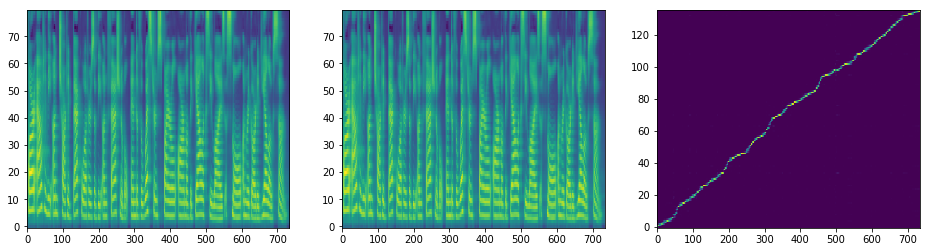

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [8]:

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



c:\users\direl\appdata\local\programs\python\python36\lib\site-packages\torch\nn\modules\module.py:489: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  result = self.forward(*input, **kwargs)
c:\users\direl\appdata\local\programs\python\python36\lib\site-packages\torch\nn\modules\module.py:489: RuntimeWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  result = self.forward(*input, **kwargs)


In [11]:
del waveglow
torch.cuda.empty_cache()